## Планирование продаж и промо кампаний игр на следующий год

Описание проекта:

Интернет-магазин "Стримчик" продает игры, для увеличения эффективности необходимо спланировать продажи и промо кампании на следующий год основываясь на данных по рейтингу и продаже игр за прошедший год.

В рамках проекта необходимо выполнить предобработку данных, проанализировать продажи по платформам, регионам, жанрам, рейтингам. Выполнить проверку гипотез о равенстве пользовательских рейтингов для 2-х платформ и 2-х жанров.

### Шаг 1. Открытие файл 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
df.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

В файле обнаружены пропуски и разные типы данных - вещественные, объекты

Проверка дубликатов:

In [4]:
df.duplicated().sum()

0

### Шаг 2. Подготовка данных

In [5]:
df[df['Name'].isna()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [6]:
df.drop([659, 14244], inplace = True)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16713 non-null object
Year_of_Release    16444 non-null float64
Genre              16713 non-null object
NA_sales           16713 non-null float64
EU_sales           16713 non-null float64
JP_sales           16713 non-null float64
Other_sales        16713 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


TBD - означает, что пользователь ещё не определился с рейтингом, т.е., это отсутствие рейтинга, заменим tbd на пустое значение:

In [8]:
df['User_Score'].replace('tbd', '', inplace = True)

In [9]:
df.query('User_Score == "tbd"')

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating


In [10]:
df['User_Score'] = pd.to_numeric(df['User_Score'])

In [12]:
df['User_Score'].sum()

54079.1

In [13]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score
count,16444.000000,16713.000000,16713.000000,16713.000000,16713.000000,8137.000000,7590.000000
mean,2006.486256,0.263302,0.145045,0.077625,0.047343,68.967679,7.125046
std,5.875525,0.813565,0.503359,0.308871,0.186742,13.938165,1.500006
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


In [14]:
df['NA_sales'].sort_values()

16714     0.00
8066      0.00
13312     0.00
3719      0.00
13313     0.00
         ...  
2        15.68
5        23.20
9        26.93
1        29.08
0        41.36
Name: NA_sales, Length: 16713, dtype: float64

В данных продажах заметен разрыв среднее значение (NA sales, например) 0,26, а максимум 21. Вероятно, есть очевидно выраженные топ игр

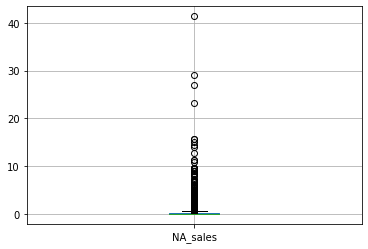

In [15]:
df.boxplot('NA_sales');

Пропущенный год релиза заполним медианой по платформе:

In [16]:
df[df['Year_of_Release'].isna()].sort_values('NA_sales', ascending = False).head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.00,0.07,73.0,NaN,E
627,Rock Band,X360,NaN,Misc,1.93,0.33,0.00,0.21,92.0,8.2,T
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+


In [17]:
df['Year_of_Release'] = df.groupby('Platform')['Year_of_Release'].apply(lambda x: x.fillna(x.median()))

In [18]:
df['Year_of_Release'].min()

1980.0

In [19]:
df[df['Year_of_Release'].isna()]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating


In [20]:
df['Year_of_Release'] = df['Year_of_Release'].astype('int')


Замена названия колонок на нижний регистр:

In [21]:
df.columns = map(str.lower, df.columns)

In [22]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [23]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df['total_sales'].sum()

8913.29

Выводы по шагу 2 - Подготовка данных:
 - Обнаружены пропуски в рейтингах 40-50%, незначительное количество в столбце год релиза, и в 2-х строках отсутствует название игры и жанра;
 - Удалены 2 строки без названия игры
 - tbd в столбце рейтинг пользователей заменен на пусто, чтобы можно было производить вычисления в столбце; 
 - в столбце рейтинг пользователей изменен тип на вещественный;
 - в столбце год заменен тип на целочисленный и пропуски на медиану по платформе;
 - названия столбцов преобразованы в нижний регистр;
 - создан столбец total_sales, суммирующий продажи

### Шаг 3 Исследовательский анализ данных 

#### 3.1 Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

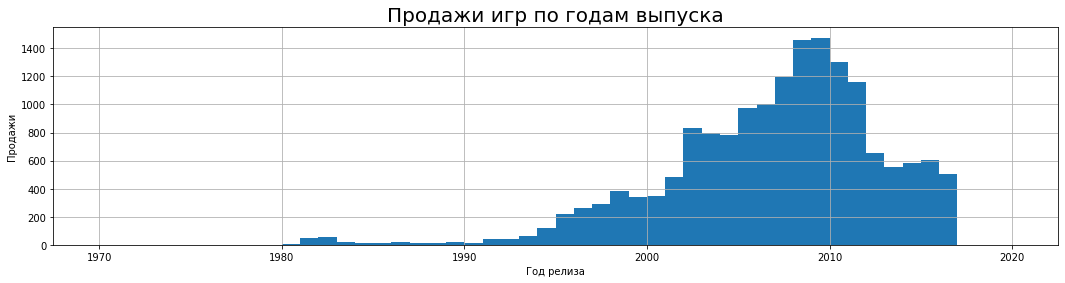

In [24]:
df.hist('year_of_release', range = (1970, 2020), bins = 50, figsize = (18,4))
plt.title('Продажи игр по годам выпуска', fontsize=20)
plt.xlabel("Год релиза")
plt.ylabel("Продажи");

In [25]:
df['years_gr'] = pd.cut(df['year_of_release'], [0, 1980, 1990,1994, 2000, 2005, 2010, 2015, 2020]) 
df.pivot_table(index='years_gr', values = 'total_sales', aggfunc=['sum', 'count']) 

,sum,count
,total_sales,total_sales
years_gr,,
"(0, 1980]",11.38,9
"(1980, 1990]",424.97,229
"(1990, 1994]",233.61,265
"(1994, 2000]",1202.40,1849
"(2000, 2005]",1996.02,3867
"(2005, 2010]",3081.04,6438
"(2010, 2015]",1833.93,3554
"(2015, 2020]",129.94,502


In [26]:
df = df.loc[(df['year_of_release'] >=1995)]
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,years_gr
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,"(2005, 2010]"
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,"(2005, 2010]"
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,"(2005, 2010]"
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38,"(1994, 2000]"
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,"(2005, 2010]"


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16210 entries, 0 to 16714
Data columns (total 13 columns):
name               16210 non-null object
platform           16210 non-null object
year_of_release    16210 non-null int64
genre              16210 non-null object
na_sales           16210 non-null float64
eu_sales           16210 non-null float64
jp_sales           16210 non-null float64
other_sales        16210 non-null float64
critic_score       8133 non-null float64
user_score         7586 non-null float64
rating             9944 non-null object
total_sales        16210 non-null float64
years_gr           16210 non-null category
dtypes: category(1), float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Имеет смысл ограничить выборку годами выпуска, берем игры, разработанные с 1995г, в продажах доля исключенных лет составляет 14% и это около 500 игр.

#### 3.2 Продажи по платформам

In [28]:
df_platf = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = \
['sum', 'count', 'mean'], margins = True).sort_values((  'sum', 'total_sales'),ascending = False).reset_index()
df_platf.columns = [['platform', 'sales_sum', 'count', 'mean']]
df_platf

,platform,sales_sum,count,mean
0,All,8243.33,16210,0.508534
1,PS2,1255.77,2161,0.581106
2,X360,971.42,1262,0.769746
3,PS3,939.65,1331,0.705973
4,Wii,907.51,1320,0.687508
5,DS,806.10,2150,0.374930
6,PS,724.83,1180,0.614263
7,GBA,317.85,822,0.386679
8,PS4,314.14,392,0.801378
9,PSP,294.05,1209,0.243218


Выберем топ 6 платформ, которые составляют почти 70% от продаж и построим графики по ним:

In [29]:
list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

In [30]:
df_top_pl = df.query('platform in @list')
df_top_pl_pv = df_top_pl.pivot_table(index ='year_of_release', columns ='platform', values='total_sales', aggfunc ='sum').reset_index()

In [31]:
df_top_pl_pv.fillna(0, inplace = True)
df_top_pl_pv
df_top_pl_pv.set_index('year_of_release', inplace=True)
df_top_pl_pv

platform,DS,PS,PS2,PS3,Wii,X360
year_of_release,,,,,,
1995,0.00,35.96,0.00,0.00,0.00,0.00
1996,0.00,94.70,0.00,0.00,0.00,0.00
1997,0.00,136.17,0.00,0.00,0.00,0.00
1998,0.00,172.77,0.00,0.00,0.00,0.00
1999,0.00,144.53,0.00,0.00,0.00,0.00
2000,0.00,96.37,39.17,0.00,0.00,0.00
2001,0.00,35.59,166.43,0.00,0.00,0.00
2002,0.00,6.67,205.38,0.00,0.00,0.00
2003,0.00,2.07,184.31,0.00,0.00,0.00


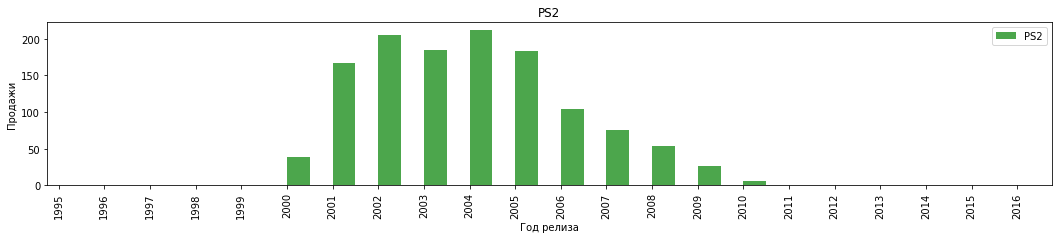

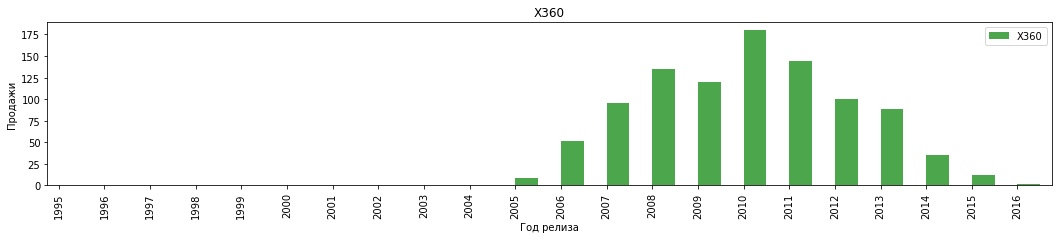

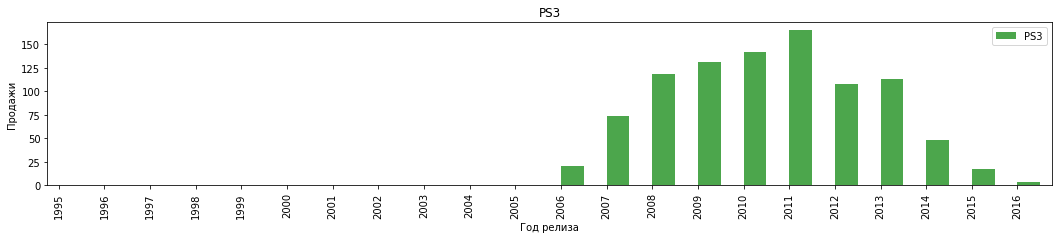

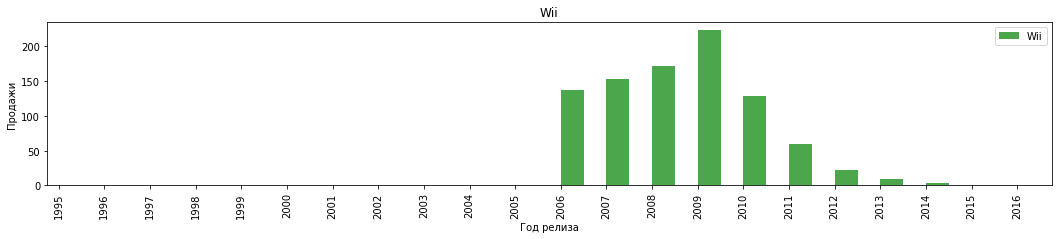

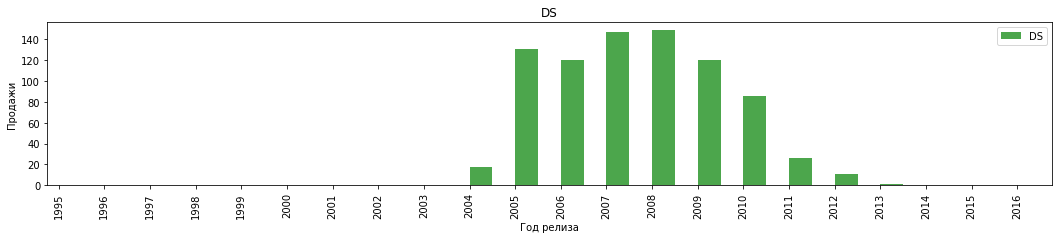

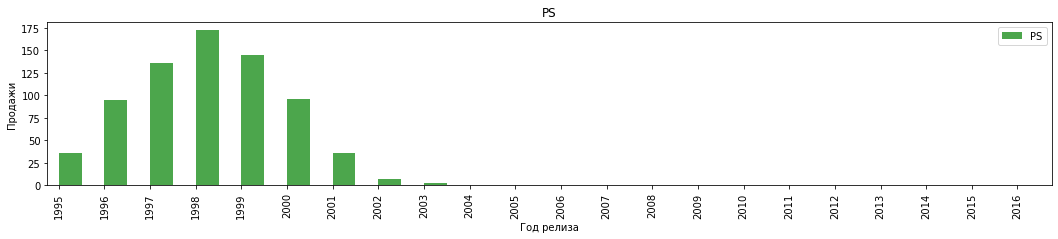

In [32]:
for i in list:
    plt.figure(figsize=(18,3))
    df_top_pl_pv[i].plot(kind = 'bar', x = 'year_of_release', legend = True, position = 0, color = 'green', alpha = 0.7)
  
    plt.title (i)
    plt.legend
    
    plt.xlabel("Год релиза")
    plt.ylabel("Продажи")
    
    plt.show()

По графикам можно заметить длительность развития платформы, в среднем 5 -6 -7 лет. Примерно половина из рассмтриваемых платформ пика продаж достигает через 3 года, другая половина имеет максимальные продажи со старта релиза, затем происходит постепенное снижение продаж выпускаемых игр.

 #### 3.3 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [33]:
df = df.loc[(df['year_of_release'] >2010)]
len(df)

4056

In [34]:
df_platf_act = df.pivot_table(index = 'platform', values = 'total_sales', aggfunc = \
['sum', 'count', 'mean'], margins = True).sort_values((  'sum', 'total_sales'),ascending = False).reset_index()
df_platf_act.columns = [['platform', 'sales_sum', 'count', 'mean']]
df_platf_act

,platform,sales_sum,count,mean
0,All,1963.87,4056,0.484189
1,PS3,453.88,733,0.619209
2,X360,380.38,498,0.763815
3,PS4,314.14,392,0.801378
4,3DS,259.00,520,0.498077
5,XOne,159.32,247,0.645020
6,PC,97.68,389,0.251105
7,Wii,95.02,197,0.482335
8,WiiU,82.19,147,0.559116
9,PSV,54.07,430,0.125744



Берем топ 5 платформ: PS3', 'X360', 'PS4', '3DS', 'XOne


In [35]:
list_act = ['PS3', 'X360', 'PS4', '3DS', 'XOne']

In [36]:
df_top_pl_act = df.query('platform in @list_act')
df_top_pl_pv_act = df_top_pl_act.pivot_table(index ='year_of_release', columns ='platform', values='total_sales', aggfunc ='sum').reset_index()

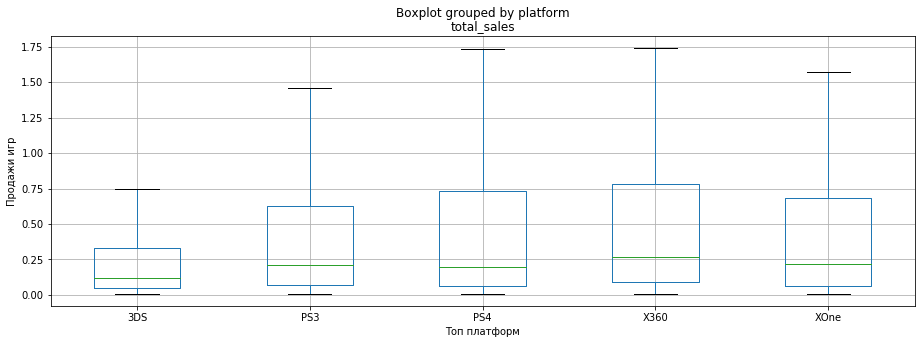

In [37]:
df_top_pl_act.boxplot('total_sales', by = 'platform', figsize = (15,5),showfliers=False)

plt.xlabel("Топ платформ")
plt.ylabel("Продажи игр");

Платформа PS3 лидер по продажам, не имеет настолько успешной игры, но вероятно имеет много игр со стабильнохорошими продажами.

2 платформы имеют похожий график - PS4 и X360 - наблюдаются игры с лучшими продажами, но положение медианыу X360 выше, чем у остальных платформ.

3DS - в конце списка топ платформ, не имеет топ игр и медиана имеет меньшее значение - большинство игр не имеют значительных продаж

#### 3.4 Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Возьмем для исследования корреляции платформу с самыми высокими продажами - PS2

In [38]:
df_ps3 = df.query('platform =="PS3"')
df_ps3

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,years_gr
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05,"(2010, 2015]"
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79,"(2010, 2015]"
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33,"(2010, 2015]"
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36,"(2010, 2015]"
81,FIFA Soccer 13,PS3,2012,Action,1.06,5.01,0.13,1.97,88.0,6.6,E,8.17,"(2010, 2015]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16628,Akatsuki no Goei Trinity,PS3,2012,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,"(2010, 2015]"
16638,Tour de France 2014,PS3,2014,Sports,0.00,0.01,0.00,0.00,NaN,NaN,E,0.01,"(2010, 2015]"
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01,"(2010, 2015]"
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01,"(2015, 2020]"


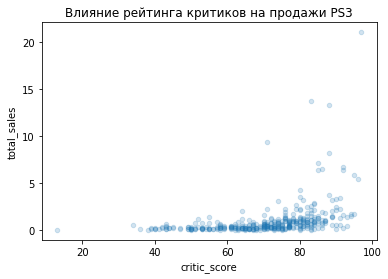

In [39]:
df_ps3.plot(x='critic_score', y='total_sales',\
kind='scatter', alpha=0.2, title = 'Влияние рейтинга критиков на продажи PS3');

In [40]:
df_ps3['critic_score'].corr(df_ps3['total_sales'])

0.3797253577883183

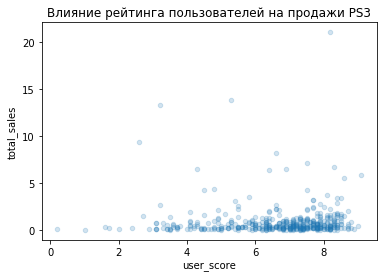

In [41]:
df_ps3.plot(x='user_score', y='total_sales',\
kind='scatter', alpha=0.2, title = 'Влияние рейтинга пользователей на продажи PS3');

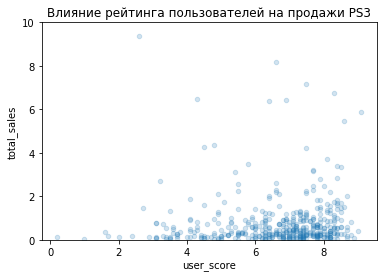

In [42]:
df_ps3.plot(x='user_score', y='total_sales',\
kind='scatter', alpha=0.2, ylim = (0,10), title = 'Влияние рейтинга пользователей на продажи PS3');

In [43]:
df_ps3['user_score'].corr(df_ps3['total_sales'])

0.01252143035253283

Судя по графикам рейтинги пользователей не коррелируют с продажами, пользователи ставят высокие оценки играм, которые продаются не очень успешно. Рассчитанная корреляция всего 1.3%

По графику критиков можно сказать, что высокие оценки реже появляются у игр с низкими продажами. Корреляция у критиков - 38%.

Соотнесите выводы с продажами игр на других платформах.

Посчитаем корреляцию по остальному списку топовых платформ и совокупно по другим платформам:

In [44]:
df_top_wo_ps3=df_top_pl_act.query('platform !="PS3"')

In [45]:
df_top_wo_ps3['critic_score'].corr(df_top_wo_ps3['total_sales'])

0.3808809793584337

In [46]:
df_top_wo_ps3['user_score'].corr(df_top_wo_ps3['total_sales'])

0.03742738717813157

In [47]:
df_ne_top=df.query('platform not in @list_act')

In [48]:
df_ne_top['critic_score'].corr(df_ne_top['total_sales'])

0.21421923014829752

In [49]:
df_ne_top['user_score'].corr(df_ne_top['total_sales'])

0.08950807619833591

Корреляция рейтинга критиков и продаж по всем остальным платформам кроме PS3 - 38%, по нетоповым платформам - 21%;
Корреляция мнений пользователей и продаж для платформ, не входящих в топ 5 - 9%. Но их рейтинг для топ платформ(искл.PS3) всего 3,7% 

#### 3.5 Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [50]:
df_genre = df.pivot_table(index = 'genre', values = 'total_sales', aggfunc =['sum', 'count', 'mean']).\
sort_values(('sum', 'total_sales'),ascending = False)
df_genre.columns = ['sum', 'qty', 'mean']
df_genre

,sum,qty,mean
genre,,,
Action,561.92,1277,0.440031
Shooter,403.23,331,1.218218
Role-Playing,245.98,469,0.524478
Sports,237.80,393,0.605089
Misc,141.35,378,0.373942
Racing,89.22,183,0.487541
Platform,89.16,123,0.724878
Fighting,66.90,159,0.420755
Simulation,50.82,139,0.365612


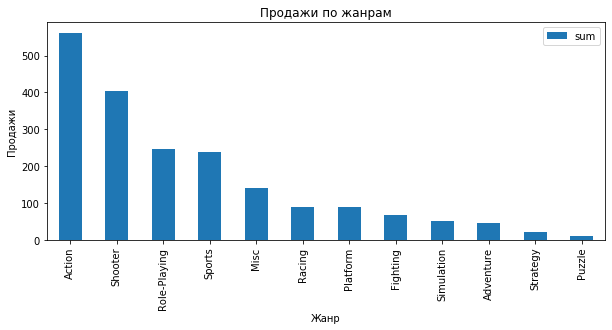

In [51]:
df_genre.plot(kind = 'bar', y = 'sum', title = 'Продажи по жанрам', figsize = (10,4))

plt.xlabel("Жанр")
plt.ylabel("Продажи");

Самые продаваемые жанры - Action, Sports, Role-Playing, Shooter, Role-Playing. В аутсайдерах Puzzle, Strategy, Adventure


Добавляем данные по жанрам, платформам и rating для определения тенденций к росту продаж:


In [52]:
df_genre_year = df.pivot_table(index = 'genre', columns='year_of_release', values = 'total_sales', aggfunc ='sum', margins = True)
df_genre_year.columns = ['2011','2012','2013', '2014', '2015', '2016', 'All']
df_genre_year.sort_values('2016', ascending = False)




,2011,2012,2013,2014,2015,2016,All
genre,,,,,,,
All,515.89,355.84,362.43,331.79,267.98,129.94,1963.87
Shooter,98.43,71.75,62.11,65.21,67.51,38.22,403.23
Action,120.40,119.25,122.91,97.23,72.02,30.11,561.92
Sports,56.71,30.42,41.19,45.15,40.84,23.49,237.80
Role-Playing,52.89,46.91,44.48,45.88,37.64,18.18,245.98
Fighting,22.41,9.18,7.09,15.85,7.90,4.47,66.90
Adventure,15.64,5.79,6.18,5.57,8.16,3.82,45.16
Platform,28.16,18.37,24.54,8.81,6.05,3.23,89.16
Racing,35.63,13.61,12.46,16.66,8.07,2.79,89.22


Лидер по продажам 2016 года - Shooter с тенденцией к росту. Прежний лидер Action - теперь #2 в рейтинге, но заметно падает. Аналогично Platform и Racing. Возрастающие тенденции у жанра Adventure


In [53]:
df_pl_year = df.pivot_table(index = 'platform', columns='year_of_release', values = 'total_sales', aggfunc ='sum', margins = True)
df_pl_year.columns = ['2011','2012','2013', '2014', '2015', '2016', 'All']
df_pl_year.sort_values('2016', ascending = False)


,2011,2012,2013,2014,2015,2016,All
platform,,,,,,,
All,515.89,355.84,362.43,331.79,267.98,129.94,1963.87
PS4,NaN,NaN,25.99,100.00,118.90,69.25,314.14
XOne,NaN,NaN,18.96,54.07,60.14,26.15,159.32
3DS,63.20,51.36,57.76,43.76,27.78,15.14,259.00
PC,35.03,23.22,12.38,13.28,8.52,5.25,97.68
WiiU,NaN,17.56,21.65,22.03,16.35,4.60,82.19
PSV,4.63,16.19,10.59,12.16,6.25,4.25,54.07
PS3,165.09,107.36,113.25,47.76,16.82,3.60,453.88
X360,143.84,99.74,88.58,34.74,11.96,1.52,380.38


Лидеры по продажам 2016 года - PS4 и XOne, находятся примерно в середине жизненного цикла. Но лидер нашего рейтинга PS3 уже практически ничего не продает в 2016.Аналогичная ситуация для X360.


In [54]:
df_rat_year = df.pivot_table(index = 'rating', columns='year_of_release', values = 'total_sales', aggfunc ='sum', margins = True)
df_rat_year.columns = ['2011','2012','2013', '2014', '2015', '2016', 'All']
df_rat_year.sort_values('2016', ascending = False)

,2011,2012,2013,2014,2015,2016,All
rating,,,,,,,
All,433.60,301.86,284.21,249.99,183.41,97.34,1550.41
M,159.27,138.43,145.14,115.44,72.75,38.35,669.38
E,102.84,87.01,67.19,57.89,49.50,25.74,390.17
T,94.23,36.32,27.68,41.66,33.61,24.12,257.62
E10+,76.77,40.10,44.20,35.00,27.55,9.13,232.75
EC,0.45,NaN,NaN,NaN,NaN,NaN,0.45
RP,0.04,NaN,NaN,NaN,NaN,NaN,0.04


По рейтингу можно только сказать, что T прирастает, а E10+ падает.


Выводы по шагу 3 - Исследовательский анализ данных:
 - убрали из расчетов игры с годом релиза до 2010г, т.к., длительность продажи платформы около 6 лет;
 - проанализированы топ5 платформ, которые дают почти 70% продаж - длительность выпуска игр на платформе около 6 лет. Лидер рейтинга PS3 не имеет отдельных игр-чемпионов, но многие игры имеют хорошие средние продажи.
 - корреляция рейтингов и продаж наблюдается, у критиков она больше, чем у пользователей. По PS2 39% vs 1,3%.
 - построен рейтинг по жанрам. Самые популярные - Action, Sports;
 - определены рекомендуемые для продажи и продвижения жанры (Shooter, Action, Adventure) и платформы PS4 и XOne. Среди рейтинга стоит обратить внимание на T (подростки)

## Шаг 4. Портрет пользователя каждого региона
Определите для пользователя каждого региона (NA, EU, JP):
Самые популярные платформы (топ-5). Опишите различия в долях продаж.
Самые популярные жанры (топ-5). Поясните разницу.
Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [55]:
df_na = df.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum').sort_values('na_sales', ascending = False).head()

df_na['na_sales'].sum()
df_na['share'] = df_na['na_sales'] / df_na['na_sales'].sum()
df_na.reset_index()

,platform,na_sales,share
0,X360,226.80,0.331690
1,PS3,171.62,0.250991
2,PS4,108.74,0.159030
3,XOne,93.12,0.136186
4,3DS,83.49,0.122102


In [56]:
df_eu = df.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum').\
sort_values('eu_sales', ascending = False).head()
df_eu['share'] = df_eu['eu_sales'] / df_eu['eu_sales'].sum()
df_eu.reset_index()

,platform,eu_sales,share
0,PS3,166.18,0.306294
1,PS4,141.09,0.260050
2,X360,117.10,0.215833
3,3DS,61.48,0.113317
4,PC,56.70,0.104506


In [57]:
df_jp = df.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
.sort_values('jp_sales', ascending = False).head()
df_jp['share'] = df_jp['jp_sales'] / df_jp['jp_sales'].sum()
df_jp.reset_index()

,platform,jp_sales,share
0,3DS,100.67,0.473184
1,PS3,50.17,0.235817
2,PSP,24.04,0.112996
3,PSV,21.91,0.102985
4,PS4,15.96,0.075018


In [58]:
df_other = df.pivot_table(index = 'platform', values = 'other_sales', aggfunc = 'sum')\
.sort_values('other_sales', ascending = False).head()
df_other['share'] = df_other['other_sales'] / df_other['other_sales'].sum()
df_other.reset_index()


,platform,other_sales,share
0,PS3,65.91,0.376586
1,PS4,48.35,0.276254
2,X360,33.13,0.189293
3,XOne,14.27,0.081534
4,3DS,13.36,0.076334


Объединим таблицы с топ платформами в одну:

In [59]:
df_top_reg =df_na.merge(df_eu, on='platform', how = 'outer')
df_top_reg = df_top_reg.merge(df_jp, on='platform', how = 'outer')
df_top_reg = df_top_reg.merge(df_other, on='platform', how = 'outer')
df_top_reg.fillna(0)

,na_sales,share_x,eu_sales,share_y,jp_sales,share_x,other_sales,share_y
platform,,,,,,,,
X360,226.80,0.331690,117.10,0.215833,0.00,0.000000,33.13,0.189293
PS3,171.62,0.250991,166.18,0.306294,50.17,0.235817,65.91,0.376586
PS4,108.74,0.159030,141.09,0.260050,15.96,0.075018,48.35,0.276254
XOne,93.12,0.136186,0.00,0.000000,0.00,0.000000,14.27,0.081534
3DS,83.49,0.122102,61.48,0.113317,100.67,0.473184,13.36,0.076334
PC,0.00,0.000000,56.70,0.104506,0.00,0.000000,0.00,0.000000
PSP,0.00,0.000000,0.00,0.000000,24.04,0.112996,0.00,0.000000
PSV,0.00,0.000000,0.00,0.000000,21.91,0.102985,0.00,0.000000


В целом топы платформ сильно пересекаются - В Северной Америке и в прочих странах полностью, с Европой за исключением 1 платформы - PS. Для Японии в топах платформа, которая не входит в топ других стран - PSP, PSV. А платформы X360 нет в лидерах, зато 3DS имеет 47%.

В Европе и прочих странах высокая доля 1 платформы - PS3, более 30%. В Северной Америке лидер X360.


In [60]:
df_gen_reg = df.pivot_table(index = 'genre', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'], aggfunc='sum')\
.sort_values('total_sales', ascending = False)
df_gen_reg

,eu_sales,jp_sales,na_sales,other_sales,total_sales
genre,,,,,
Action,200.57,64.26,232.44,64.65,561.92
Shooter,148.08,11.93,194.64,48.58,403.23
Role-Playing,62.35,80.03,83.89,19.71,245.98
Sports,88.83,11.11,108.86,29.00,237.80
Misc,40.16,17.60,70.93,12.66,141.35
Racing,41.06,5.66,32.22,10.28,89.22
Platform,30.55,12.13,38.28,8.20,89.16
Fighting,16.24,12.38,31.63,6.65,66.90
Simulation,19.72,11.64,15.89,3.57,50.82


In [61]:
df_gen_reg['eu_sales_%'] = df_gen_reg['eu_sales'] / (df_gen_reg['eu_sales'].sum())*100
df_gen_reg['jp_sales_%'] = df_gen_reg['jp_sales'] / (df_gen_reg['jp_sales'].sum())*100
df_gen_reg['na_sales_%'] = df_gen_reg['na_sales'] / (df_gen_reg['na_sales'].sum())*100
df_gen_reg['other_sales_%'] = df_gen_reg['other_sales'] / (df_gen_reg['other_sales'].sum())*100
col = ['eu_sales_%','jp_sales_%','na_sales_%','other_sales_%']
df_gen_reg[col]

,eu_sales_%,jp_sales_%,na_sales_%,other_sales_%
genre,,,,
Action,29.796622,26.063679,27.868165,30.768132
Shooter,21.998722,4.838775,23.336171,23.120122
Role-Playing,9.262698,32.459947,10.057909,9.380354
Sports,13.196559,4.506185,13.051662,13.801637
Misc,5.966158,7.138511,8.504082,6.025128
Racing,6.099862,2.295680,3.862985,4.892442
Platform,4.538499,4.919895,4.589543,3.902532
Fighting,2.412610,5.021294,3.792248,3.164858
Simulation,2.929598,4.721152,1.905116,1.699029


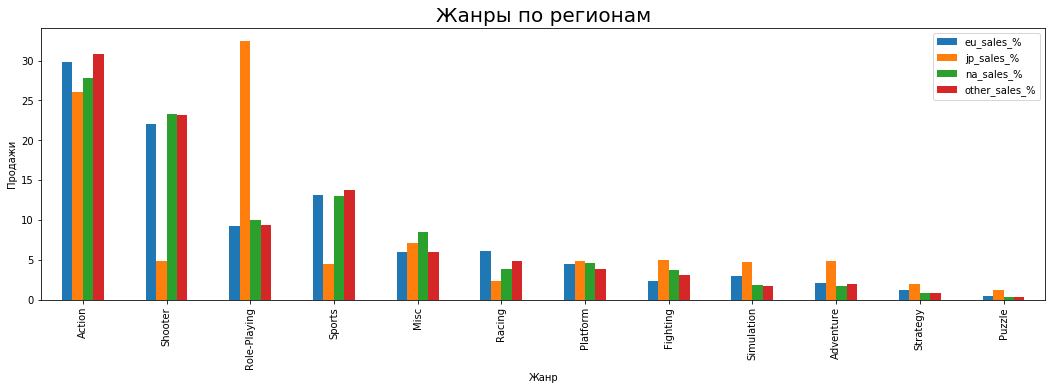

In [72]:
df_gen_reg[col].plot(kind= 'bar', figsize = (18, 5))
plt.title('Жанры по регионам', fontsize=20)
plt.xlabel("Жанр")
plt.ylabel("Продажи");

В Северной Америке, Европе и прочих странах больше доля жанров Action, Shooter, Sports. В Японии - Role-Plаying (32%), а доля Shooter, Sport, Racing очеь мала. 

In [63]:
df_rating_reg = df.pivot_table(index = 'rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
df_rating_reg['eu_rating_%'] = df_rating_reg['eu_sales'] / (df_rating_reg['eu_sales'].sum())*100
df_rating_reg['jp_rating_%'] = df_rating_reg['jp_sales'] / (df_rating_reg['jp_sales'].sum())*100
df_rating_reg['na_rating_%'] = df_rating_reg['na_sales'] / (df_rating_reg['na_sales'].sum())*100
df_rating_reg['other_rating_%'] = df_rating_reg['other_sales'] / (df_rating_reg['other_sales'].sum())*100
df_rating_reg.sort_values('na_sales', ascending = False)

,eu_sales,jp_sales,na_sales,other_sales,eu_rating_%,jp_rating_%,na_rating_%,other_rating_%
rating,,,,,,,,
M,251.01,26.79,309.33,82.25,45.130261,24.759704,43.567606,46.727645
E,141.94,36.68,170.58,40.97,25.520056,33.900185,24.025352,23.275764
E10+,79.08,11.23,118.34,24.10,14.218163,10.378928,16.667606,13.691626
T,84.13,33.50,111.33,28.66,15.126126,30.961183,15.680282,16.282241
EC,0.00,0.00,0.42,0.03,0.000000,0.000000,0.059155,0.017044
RP,0.03,0.00,0.00,0.01,0.005394,0.000000,0.000000,0.005681


Комментарии по рейтингу ESRB: E - имеет бОльшую долю во всех регионах, T - так же значим в Японии

Выводы по шагу 4 - Портрет пользователя каждого региона:

Был проведен анализ по особенностям пользователей в зависимости от региона - топы платформ, они существенно пересекаются. Есть отличия для Японских пользователей. Выявлены предпочтения по жанрам, так же нетипичная картина по Японии, выделяется жанр Role-Plаying. И для Японии значительная доля продаж у рейтинга T (подростки)

In [64]:
df.pivot_table(index = 'rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,141.94,36.68,170.58,40.97
E10+,79.08,11.23,118.34,24.10
EC,0.00,0.00,0.42,0.03
M,251.01,26.79,309.33,82.25
RP,0.03,0.00,0.00,0.01
T,84.13,33.50,111.33,28.66


## Шаг 5. Проверка гипотезы


H_0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H_1 - Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые

In [65]:
df_xbox = df.query('platform == "XOne" and user_score>0')
df_pc = df.query('platform == "PC" and user_score>0')

In [66]:
alpha = 0.05
results = st.ttest_ind(
    df_xbox['user_score'], 
    df_pc['user_score'])

results.pvalue

0.6267602271422398

Pvalue существенно выше alpha - 63%. Поэтому нулевую гипотезу мы принимаем.

H_0 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)  одинаковые

H_1 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)  не одинаковые

In [67]:
df_action = df.query('genre == "Action" and user_score>0')
df_sport = df.query('genre == "Sports" and user_score>0')

In [68]:
alpha = 0.05
results = st.ttest_ind(
    df_action['user_score'], 
    df_sport['user_score'])

results.pvalue

2.65939241959414e-24

Pvalue существенно ниже alpha, поэтому нулевую гипотезу мы точно отвергаем в пользу альтернативной - Средние пользовательские рейтинги жанров Action и Sports не одинаковые

Выводы по шагу 5: проверены 2 гипотезы о равенстве пользовательских рейтингов для 2-х платформ и 2-х жанров. Первую принимаем, вторую нет.

### Общий вывод по проекту:

1. Обработка данных:
    
 - Обнаружены пропуски в рейтингах, около 40-50%, незначительное количество в столбце год релиза, и в 2-х строках отсутствует название игры и жанра, эти строки удалил;
 - tbd в столбце рейтинг пользователей заменен на пусто, тип данных приведен к вещественному для возможности дальнейших вычислений; 
 - тип данных в столбце год заменен на целочисленный, а пропуски - на медиану по платформе;
 - названия столбцов преобразованы в нижний регистр;
 - создан столбец total_sales, суммирующий продажи


2. Исследование данных:

 - из расчетов исключили игры с годом релиза до 2011, т.к., жизненный цикл платформы около 6 лет;
 - проанализированы топ-5 платформ, которые дают более 75% продаж, выявлено, что длительность выпуска игр на платформе около 6 лет. Лидер рейтинга PS3 не имеет отдельных игр-чемпионов, но многие игры имеют хорошие средние продажи.
 - корреляция рейтингов критиков и продаж больше, чем у пользователей. По PS3 39% vs 1.3%.
 - построен рейтинг по жанрам. Самые популярные - Action, Sports.


3. Портрет пользователя по регионам:

 - проведен анализ особенностей пользователей в зависимости от региона - топ5 платформ, выяснилось, что они существенно пересекаются. Обнаружены отличия для японских пользователей;
 - выявлены предпочтения по жанрам, так же нетипичная картина по Японии, выделяется жанр Role-Plаying;
 - для Японии значительная доля продаж имеет рейтинга T (подростки).


4. Рекомендации по планированию продаж на следующий год:
 - с учетом тенденций продаж жанров, стоит сконцентрироваться на Shooter, Action, Adventure
 - Потенциал хороших продаж есть у платформ - лидеров PS4 и XOne
 - Рейтинга стоит обратить внимание на T (подростки) 


5. Проверка гипоте:

 - проверены 2 гипотезы о равенстве пользовательских рейтингов для 2-х платформ и 2-х жанров. Гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC принимаем. Вторую - о равенстве пользовательских рейтингов для жанров Sport и Action  -отвергаем.
 
 